<a href="https://colab.research.google.com/github/Laksopan23/Brain-Tumor-Detection-Models/blob/sageevan-yolo/Yolov11n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 1: Dataset Exploration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import random

# Path to my dataset
data_dir = "/content/drive/MyDrive/DL_Project"
classes = ["glioma", "meningioma", "pituitary", "notumor"]

In [3]:
image_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
print("Total Images per Class:")
for cls, count in image_counts.items():
    print(f"{cls}: {count}")

Total Images per Class:
glioma: 1621
meningioma: 1645
pituitary: 1757
notumor: 2000


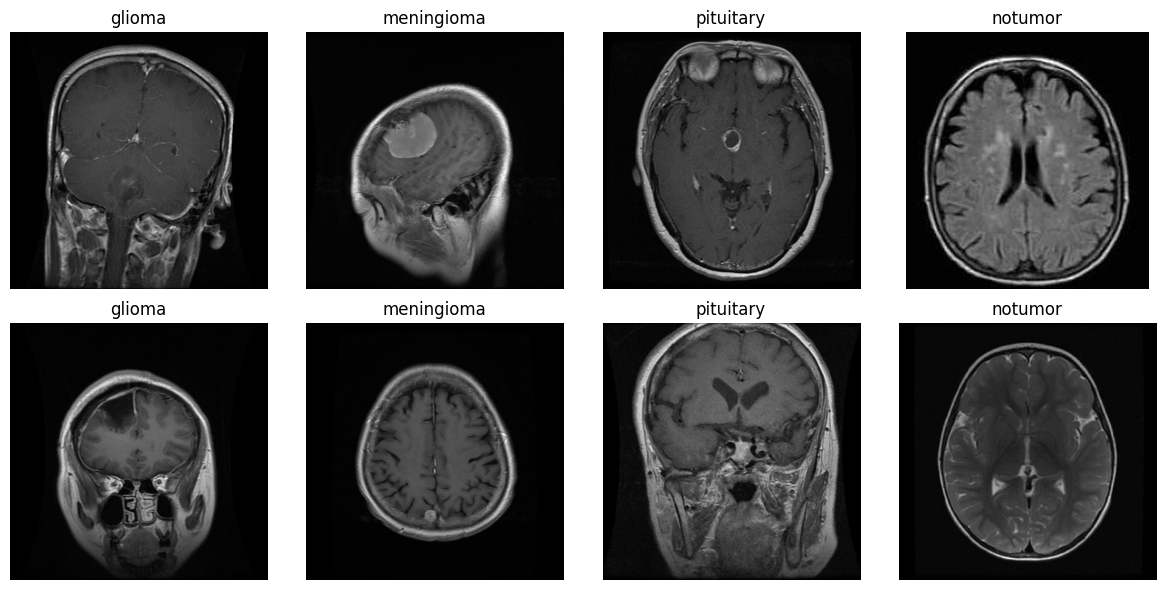

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, cls in enumerate(classes):
    img_dir = os.path.join(data_dir, cls)
    sample_imgs = random.sample(os.listdir(img_dir), 2)
    for j, img_name in enumerate(sample_imgs):
        img_path = os.path.join(img_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[j, i].imshow(img)
        axes[j, i].set_title(f"{cls}")
        axes[j, i].axis("off")
plt.tight_layout()
plt.show()

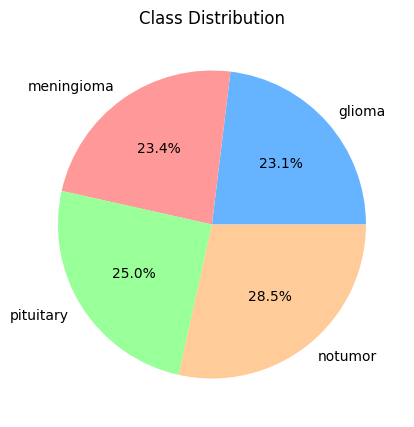

In [5]:
labels = list(image_counts.keys())
sizes = list(image_counts.values())

plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=["#66b3ff", "#ff9999", "#99ff99", "#ffcc99"])
plt.title("Class Distribution")
plt.show()

# Phase 2: Data Preprocessing

In [6]:
import os, random, shutil, csv
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Reproducibility
random.seed(42)

# Source (your current dataset with yes/ and no/)
SRC = Path("/content/drive/MyDrive/DL_Project")
CLASSES = ["glioma", "meningioma", "pituitary", "notumor"]

# Target root for YOLO/Keras (train/val/test folders will be created here)
ROOT = Path("/content/drive/MyDrive/brain_tumor_dataset_root")

# Allowed image extensions
EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff", ".webp"}

SRC, ROOT, CLASSES, EXTS

(PosixPath('/content/drive/MyDrive/DL_Project'),
 PosixPath('/content/drive/MyDrive/brain_tumor_dataset_root'),
 ['glioma', 'meningioma', 'pituitary', 'notumor'],
 {'.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff', '.webp'})

In [7]:
for split in ["train", "val", "test"]:
    for c in CLASSES:
        (ROOT / split / c).mkdir(parents=True, exist_ok=True)
print("Created (or verified) folder structure under:", ROOT)

Created (or verified) folder structure under: /content/drive/MyDrive/brain_tumor_dataset_root


In [8]:
def valid_image(p: Path) -> bool:
    if p.suffix.lower() not in EXTS:
        return False
    try:
        with Image.open(p) as im:
            im.verify()  # quick corruption check
        return True
    except Exception:
        return False

In [9]:
files = {c: [] for c in CLASSES}
bad = []

for c in CLASSES:
    src_dir = SRC / c
    assert src_dir.exists(), f"Missing folder: {src_dir}"
    for p in src_dir.glob("*"):
        (files[c].append(p) if valid_image(p) else bad.append(str(p)))

print(f"Corrupted/non-image files found: {len(bad)}")
if bad:
    print("Examples:", bad[:5])

for c in CLASSES:
    print(f"{c} valid images:", len(files[c]))

Corrupted/non-image files found: 0
glioma valid images: 1621
meningioma valid images: 1645
pituitary valid images: 1757
notumor valid images: 2000


In [10]:
splits = {"train": [], "val": [], "test": []}

for c in CLASSES:
    imgs = files[c][:]
    random.shuffle(imgs)

    n = len(imgs)
    n_train_pool = int(0.8 * n)      # 80% to train pool
    train_pool, test = imgs[:n_train_pool], imgs[n_train_pool:]

    n_val = int(0.1 * len(train_pool))  # 10% of the train pool -> val
    val = train_pool[:n_val]
    train = train_pool[n_val:]

    # Copy files to destination split folders
    for p in train:
        dst = ROOT / "train" / c / p.name
        shutil.copy2(p, dst)
        splits["train"].append((c, str(p), str(dst)))

    for p in val:
        dst = ROOT / "val" / c / p.name
        shutil.copy2(p, dst)
        splits["val"].append((c, str(p), str(dst)))

    for p in test:
        dst = ROOT / "test" / c / p.name
        shutil.copy2(p, dst)
        splits["test"].append((c, str(p), str(dst)))

print("Split + copy completed.")

Split + copy completed.


In [11]:
for split in ["train", "val", "test"]:
    counts = {c: len(list((ROOT / split / c).glob("*"))) for c in CLASSES}
    print(split, counts)


train {'glioma': 1167, 'meningioma': 1185, 'pituitary': 1265, 'notumor': 1440}
val {'glioma': 129, 'meningioma': 131, 'pituitary': 140, 'notumor': 160}
test {'glioma': 325, 'meningioma': 329, 'pituitary': 352, 'notumor': 400}


In [12]:
man_csv = ROOT / "manifest.csv"
with open(man_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["split", "class", "src_path", "dest_path"])
    for split in ["train", "val", "test"]:
        for c, src, dst in splits[split]:
            w.writerow([split, c, src, dst])
print("Saved manifest:", man_csv)

Saved manifest: /content/drive/MyDrive/brain_tumor_dataset_root/manifest.csv


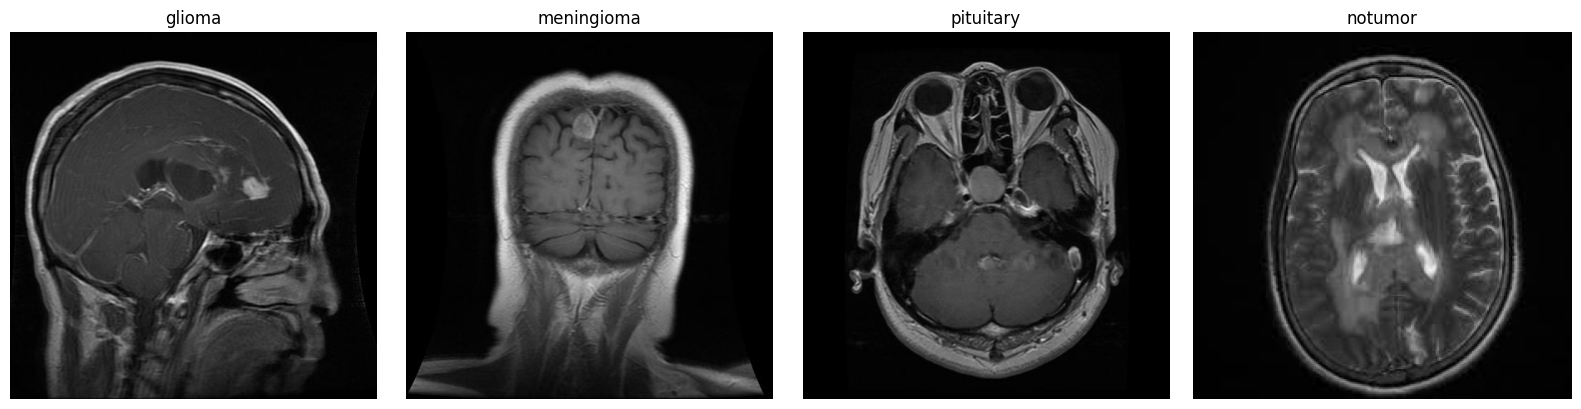

In [13]:
def show_samples(split="train", k=6):
    paths = []
    for c in CLASSES:
        imgs = list((ROOT / split / c).glob("*"))
        if imgs:
            # sample min(k//len(CLASSES), len(imgs)) per class
            paths += random.sample(imgs, min(max(1, k // len(CLASSES)), len(imgs)))

    if not paths:
        print(f"No images found in {split} split.")
        return

    n = len(paths)
    rows = (n + 3) // 4  # up to 4 images per row
    cols = min(4, n)

    plt.figure(figsize=(4 * cols, 4 * rows))
    for i, p in enumerate(paths):
        img = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.parent.name)
    plt.tight_layout()
    plt.show()

# Example call
show_samples("train", k=6)

#Phase 3: Model Development

In [14]:
!pip -q install -U ultralytics
from ultralytics import YOLO
import os, csv, glob
from pathlib import Path

root_dir = "/content/drive/MyDrive/brain_tumor_dataset_root"  # train/val/test inside
assert os.path.isdir(root_dir)

# Callback: compute train split accuracy each epoch (fast; uses eval mode)
def on_fit_epoch_end(trainer):
    try:
        m = trainer.model
        # short eval on train split; adjust batch/imgsz to your GPU/TPU
        res = m.val(data=root_dir, split='train', imgsz=224, batch=64, verbose=False, plots=False)
        train_top1 = res.results_dict.get('metrics/accuracy_top1', None)
        out = Path(trainer.save_dir) / "extra_train_metrics.csv"
        newfile = not out.exists()
        with open(out, "a", newline="") as f:
            w = csv.writer(f)
            if newfile:
                w.writerow(["epoch","train_top1"])
            w.writerow([int(trainer.epoch), float(train_top1) if train_top1 is not None else ""])
    except Exception as e:
        print("[warn] train-accuracy callback failed:", e)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [15]:
model = YOLO("yolo11n-cls.pt")
model.add_callback("on_fit_epoch_end", on_fit_epoch_end)

results = model.train(
    data=root_dir,
    epochs=30,
    imgsz=224,
    batch=32,
    patience=10,
    verbose=True,
    plots=True
)

print("Best run directory:", model.trainer.best)

Ultralytics 8.3.212 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/brain_tumor_dataset_root, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0

In [16]:
test_metrics = model.val(split="test", imgsz=224, batch=32)
print("Test metrics dict:", test_metrics.results_dict)

Ultralytics 8.3.212 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,531,148 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/brain_tumor_dataset_root/train... found 5057 images in 4 classes ✅ 
val: /content/drive/MyDrive/brain_tumor_dataset_root/val... found 560 images in 4 classes ✅ 
test: /content/drive/MyDrive/brain_tumor_dataset_root/test... found 1406 images in 4 classes ✅ 
test: Fast image access ✅ (ping: 0.5±0.3 ms, read: 5.9±2.6 MB/s, size: 18.5 KB)
test: Scanning /content/drive/MyDrive/brain_tumor_dataset_root/test... 1406 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1406/1406 212.2it/s 6.6s
test: New cache created: /content/drive/MyDrive/brain_tumor_dataset_root/test.cache
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 44/44 3.7it/s 11.8s
                   all       0.99          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/

#Phase 4: Unified Evaluation

In [17]:
# --- Unified Evaluation (fast + multiclass) ---
import os, csv
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

root_dir = "/content/drive/MyDrive/brain_tumor_dataset_root"
test_root = Path(root_dir) / "test"
assert test_root.exists(), f"Missing test dir: {test_root}"

# Class order taken from folder names (keeps your mapping consistent with training)
test_classes = sorted([d.name for d in test_root.iterdir() if d.is_dir()])
idx_of = {c:i for i,c in enumerate(test_classes)}

rows = [("image_path","true_label","pred_label","prob")]
y_true, y_pred = [], []

# Gather all test image paths with labels
all_paths, all_labels = [], []
for cls_name in test_classes:
    cls_dir = test_root / cls_name
    paths = [p for p in cls_dir.glob("*") if p.is_file()]
    if not paths:
        print(f"[warn] No files in {cls_dir}")
    all_paths.extend(paths)
    all_labels.extend([idx_of[cls_name]] * len(paths))

# Batched predictions for speed (ultralytics will batch internally)
# You can tweak imgsz/batch for memory
preds = model.predict([str(p) for p in all_paths], imgsz=224, verbose=False)

for p, y in zip(all_paths, all_labels):
    r = preds.pop(0)                  # each r corresponds to one image
    top1 = int(r.probs.top1)
    conf = float(r.probs.top1conf)
    rows.append((str(p), y, top1, conf))
    y_true.append(y)
    y_pred.append(top1)

# Save per-sample predictions
csv_path = "yolo_test_predictions.csv"
with open(csv_path, "w", newline="") as f:
    csv.writer(f).writerows(rows)
print("Saved:", csv_path)

# --- Multi-class metrics ---
acc = accuracy_score(y_true, y_pred)

# Weighted = accounts for class imbalance
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

# Macro = unweighted mean across classes
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

cm = confusion_matrix(y_true, y_pred)
per_class_acc = {
    cls: (cm[i, i] / cm[i].sum() if cm[i].sum() else 0.0)
    for i, cls in enumerate(test_classes)
}

print(f"\nAccuracy: {acc:.4f}")
print(f"Weighted — P: {prec_w:.4f}  R: {rec_w:.4f}  F1: {f1_w:.4f}")
print(f"Macro    — P: {prec_m:.4f}  R: {rec_m:.4f}  F1: {f1_m:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nPer-class accuracy:", per_class_acc)
print("\nPer-class report:\n",
      classification_report(y_true, y_pred, target_names=test_classes, zero_division=0))


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Saved: yolo_test_predictions.csv

Accuracy: 0.9900
Weighted — P: 0.9901  R: 0.9900  F1: 0.9900
Macro    — P: 0.9897  R: 0.9895  F1: 0.9896

Confusion Matrix:
 [[319   6   0   0]
 [  2 324   1   2]
 [  1   0 399   0]
 [  0   1   1 350]]

Per-class accuracy: {'glioma': np.float64(0.9815384615384616), 'meningioma': np.float64(0.9848024316109423), 'notumor': np.float64(0.9975), 'pituitary': np.float64(0.9943181818181818)}

Per-class report:
               p

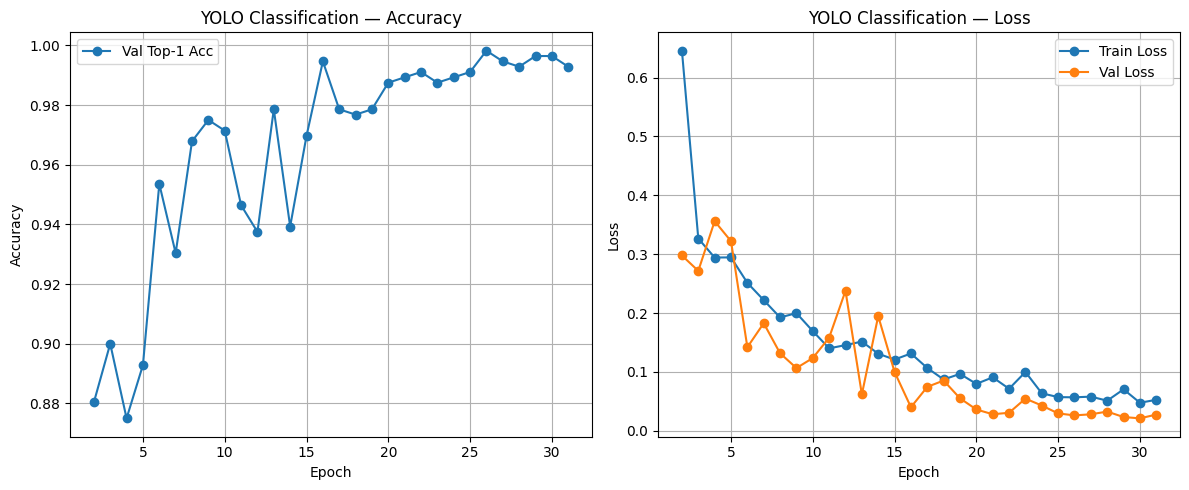

In [18]:
import pandas as pd, matplotlib.pyplot as plt, glob, os
from pathlib import Path

# Find the latest run folder
runs = sorted(glob.glob("runs/classify/*/results.csv"), key=os.path.getmtime)
assert runs, "No results.csv found."
results_csv = runs[-1]
run_dir = Path(results_csv).parent
hist = pd.read_csv(results_csv)

ep = hist['epoch'] + 1
va_cols = [c for c in ['val/metrics/accuracy_top1','metrics/accuracy_top1','metrics/accuracy'] if c in hist.columns]
va_a = hist[va_cols[0]]

extra_csv = run_dir / "extra_train_metrics.csv"
if extra_csv.exists():
    extra = pd.read_csv(extra_csv)
    # epochs in callback are 0-indexed; align to 1-based for plotting
    tr = extra.sort_values('epoch')
    tr_ep = tr['epoch'] + 1
    tr_a  = tr['train_top1']
else:
    tr_ep = None
    tr_a  = None

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
if tr_a is not None:
    plt.plot(tr_ep, tr_a, marker='o', label='Train Top-1 Acc')
plt.plot(ep, va_a, marker='o', label='Val Top-1 Acc')
plt.title('YOLO Classification — Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(ep, hist['train/loss'], marker='o', label='Train Loss')
plt.plot(ep, hist['val/loss'], marker='o', label='Val Loss')
plt.title('YOLO Classification — Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

In [20]:
import numpy as np

# best epoch by highest val accuracy (or lowest val loss if you prefer)
best_idx_acc = int(np.argmax(va_a.values))
best_epoch = int(ep.iloc[best_idx_acc])
gap_acc = float(tr_a.iloc[best_idx_acc] - va_a.iloc[best_idx_acc])

# trend heuristic: last 5 epochs, is train loss ↓ while val loss ↑ ?
last_k = min(5, len(ep))
train_trend = tr_l.tail(last_k).diff().mean()   # negative is going down
val_trend   = va_l.tail(last_k).diff().mean()   # positive is going up
overfit_flag = (train_trend < 0) and (val_trend > 0)

print(f"Best epoch (by val acc): {best_epoch}")
print(f"Train Acc @best: {tr_a.iloc[best_idx_acc]:.4f} | Val Acc @best: {va_a.iloc[best_idx_acc]:.4f} | Gap: {gap_acc:.4f}")
print(f"Train loss trend (last {last_k} epochs): {train_trend:+.4f} (↓ is good)")
print(f"Val   loss trend (last {last_k} epochs): {val_trend:+.4f} (↑ suggests overfitting)")
print("Overfitting heuristic:", "POSSIBLE" if overfit_flag else "Not obvious")

Best epoch (by val acc): 26
Train Acc @best: 0.9982 | Val Acc @best: 0.9982 | Gap: 0.0000
Train loss trend (last 5 epochs): -0.0014 (↓ is good)
Val   loss trend (last 5 epochs): -0.0001 (↑ suggests overfitting)
Overfitting heuristic: Not obvious


<Figure size 500x500 with 0 Axes>

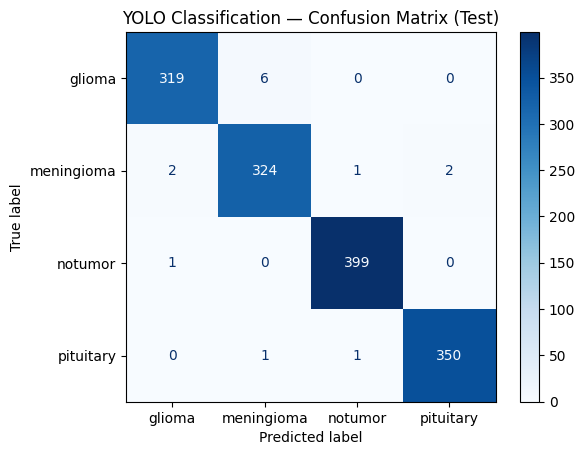

Confusion Matrix raw:
 [[319   6   0   0]
 [  2 324   1   2]
 [  1   0 399   0]
 [  0   1   1 350]]
Per-class accuracy: {'glioma': np.float64(0.9815384615384616), 'meningioma': np.float64(0.9848024316109423), 'notumor': np.float64(0.9975), 'pituitary': np.float64(0.9943181818181818)}


In [21]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# Ensure y_true, y_pred, test_classes are in memory from your earlier cell
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_classes)

plt.figure(figsize=(5,5))
disp.plot(cmap='Blues', values_format='d')
plt.title('YOLO Classification — Confusion Matrix (Test)')
plt.grid(False)
plt.show()

print("Confusion Matrix raw:\n", cm)
print("Per-class accuracy:",
      {cls: cm[i,i]/cm[i].sum() if cm[i].sum() else 0.0 for i, cls in enumerate(test_classes)})

Using 800 images total for histogram.


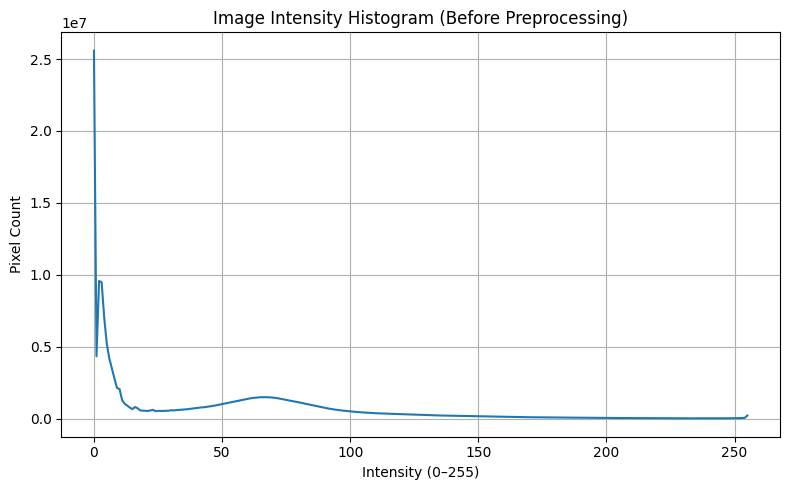

In [22]:
# ✅ Image Intensity Histogram (Before Preprocessing)

from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random, os

# ---- Config ----
DATA_DIR = Path("/content/drive/MyDrive/DL_Project")  # your raw folders
CLASSES  = ["glioma", "meningioma", "pituitary", "notumor"]
SAMPLE_PER_CLASS = 200   # adjust if needed (uses all if class has fewer)

# ---- Collect image paths ----
all_paths = []
for cls in CLASSES:
    cls_dir = DATA_DIR / cls
    assert cls_dir.exists(), f"Missing folder: {cls_dir}"
    imgs = [p for p in cls_dir.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".tif",".tiff",".webp"}]
    random.shuffle(imgs)
    all_paths.extend(imgs[:min(SAMPLE_PER_CLASS, len(imgs))])

print(f"Using {len(all_paths)} images total for histogram.")

# ---- Aggregate histogram over images ----
hist = np.zeros(256, dtype=np.int64)
for p in all_paths:
    try:
        im = Image.open(p).convert("L")  # grayscale, no preprocessing
        arr = np.array(im, dtype=np.uint8)
        h, _ = np.histogram(arr, bins=256, range=(0,255))
        hist += h
    except Exception as e:
        # skip unreadable/corrupted files silently
        pass

# ---- Plot ----
plt.figure(figsize=(8,5))
plt.plot(np.arange(256), hist)
plt.title("Image Intensity Histogram (Before Preprocessing)")
plt.xlabel("Intensity (0–255)")
plt.ylabel("Pixel Count")
plt.grid(True)
plt.tight_layout()
plt.show()
